<h1 align="center">Cohort Analysis</h1> 
<h2 align="center">Amrit Sandhir</h2> 

### I: Use Case
### II: Exploratory Data Analysis
### III. Analysis
### IV: Conclusion

### I: Use Case

Many businesses and researchers are interested in behaviors and dynamics of certain entities of interest.  This could involve anything from the lifetime usage for a model of airplanes produced in given years, the birth rates of countries over time, or the purchase rates of consumers that signed up for an account on an ecommerce site.  What these businesses/researchers are aiming to understand is how the measure of interest for a given group evolves over time.  In statistical terminology, these are known as panel studies where the groupings' measure of interest is tracked across time.   

Cohort analysis is a useful tool to understand trends across time for a given group (cohort), as well as among different cohorts.  In general, cohort analysis requires three components: 

* a cohort grouping, which is typically based on start date (e.g, month users sign up for an account) or triggerring event 
* time series data, and 
* the measure of interest.

The measure of interest is aggregated in the time series at periodic intervals for the cohorts and typically displayed in visualizations.  This allows us to identify trends and dynamics among cohorts based on their inceptions.  For example, if we see the metrics in the time series shifting between cohort X and cohort Y it can alert us and induce further research and understanding.  This becomes more relevant when we compare higher cardinality of cohorts.

For the purposes of this analysis, the legislators dataset will be used.  This data can be found on https://github.com/unitedstates/congress-legislators, and contains information on all historical and current members of US Congress.  The information includes unique identifiers of legislators, start dates (including first) and end dates (including last) of the legislators' terms, and which chamber they belong to ('rep'=House of Representatives, 'sen'=Senate).  An abbreivated data dictionary is provied below for reference.

The question we will ask is what is tenure length (in years) and retention rate for cohorts over time.  The cohort groupings are defined by their first (initial) start dates (e.g., cohort 1789 includes members who first joined congress in 1789)  The measure of interest is whether they go onto serve sucessive terms.

We will look at the Senate and House of Representative members separately to see if there are meaningful differences in their retention rates and tenure.  

<h1 align="center">Data Dictionary</h1> 

| Column      | Description       | Data Type     | Example 
| :---       |     :----         |         :--- |  :----    
| bioguide|  unique legislator identifier | object | A000001
| first_name |  legislator first name | object | Fred 
| last_name |  legislator last name | object | Aandahl 
| gender |  legislator gender (M,F) | object | M 
| birthday |  legislator birthday | datetime | 1897-04-09
| state |  legislator state | object | ND
| type |  chamber ('rep'=House of Representatives, 'sen'=Senate)| object | rep 
| party |  legislator political party affiliation | object | Republican 
| start_term |  legislator term start date  | datetime | 1951-01-03 
| end_term |  legislator term end date | datetime | 1953-01-03 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
from IPython.core.display import HTML

In [2]:
#URL to JSON file location for historical members of Congress
url='https://theunitedstates.io/congress-legislators/legislators-historical.json'

response=requests.get(url)
data=response.json()

#normalize nested JSON object into dataframe
legislators_df_hist=pd.json_normalize(data, 'terms', [['id', 'bioguide'], 
                                                      ['name', 'first'], 
                                                      ['name', 'last'],
                                                      ['bio', 'gender'],
                                                      ['bio', 'birthday']
                                                     ], errors='ignore')

#cleanups
legislators_df_hist=(legislators_df_hist.assign(start_term=lambda x: pd.to_datetime(legislators_df_hist['start']),
                                               end_term=lambda x: pd.to_datetime(legislators_df_hist['end']),
                                               bioguide=lambda x: legislators_df_hist['id.bioguide'],
                                               first_name=lambda x: legislators_df_hist['name.first'],
                                               last_name=lambda x: legislators_df_hist['name.last'], 
                                               gender=lambda x: legislators_df_hist['bio.gender'],
                                               birthday=lambda x: pd.to_datetime(legislators_df_hist['bio.birthday']))
                                               .drop(['start', 'end', 'id.bioguide', 
                                                      'name.first', 'name.last',
                                                      'bio.gender', 'bio.birthday']
                                                     , axis=1)
                    )

In [3]:
#URL to JSON file location for current members of Congress

url='https://theunitedstates.io/congress-legislators/legislators-current.json'
response=requests.get(url)
data=response.json()

#normalize nested JSON object into dataframe
legislators_df_curr=pd.json_normalize(data, 'terms', [['id', 'bioguide'], 
                                                      ['name', 'first'], 
                                                      ['name', 'last'],
                                                      ['bio', 'gender'],
                                                      ['bio', 'birthday']
                                                     ], errors='ignore')

#cleanups
legislators_df_curr=(legislators_df_curr.assign(start_term=lambda x: pd.to_datetime(legislators_df_curr['start']),
                                               end_term=lambda x: pd.to_datetime(legislators_df_curr['end']),
                                               bioguide=lambda x: legislators_df_curr['id.bioguide'],
                                               first_name=lambda x: legislators_df_curr['name.first'],
                                               last_name=lambda x: legislators_df_curr['name.last'], 
                                               gender=lambda x: legislators_df_curr['bio.gender'],
                                               birthday=lambda x: pd.to_datetime(legislators_df_curr['bio.birthday']))
                                               .drop(['start', 'end', 'id.bioguide', 
                                                      'name.first', 'name.last',
                                                      'bio.gender', 'bio.birthday']
                                                     , axis=1)
                    )

In [4]:
#stacking historical and current members 
legislators_df=pd.concat([legislators_df_hist, legislators_df_curr])

legislators_df=legislators_df[['bioguide', 'first_name', 'last_name', 'gender',
                               'birthday', 'state', 'type', 'party', 'start_term', 'end_term']]

print(legislators_df.dtypes)

HTML(legislators_df.sort_values(by=['bioguide', 'start_term']).head().to_html())


bioguide              object
first_name            object
last_name             object
gender                object
birthday      datetime64[ns]
state                 object
type                  object
party                 object
start_term    datetime64[ns]
end_term      datetime64[ns]
dtype: object


,bioguide,first_name,last_name,gender,birthday,state,type,party,start_term,end_term
25109,A000001,Fred,Aandahl,M,1897-04-09,ND,rep,Republican,1951-01-03,1953-01-03
29509,A000002,Watkins,Abbitt,M,1908-05-21,VA,rep,Democrat,1947-01-03,1949-01-03
29510,A000002,Watkins,Abbitt,M,1908-05-21,VA,rep,Democrat,1949-01-03,1951-01-03
29511,A000002,Watkins,Abbitt,M,1908-05-21,VA,rep,Democrat,1951-01-03,1953-01-03
29512,A000002,Watkins,Abbitt,M,1908-05-21,VA,rep,Democrat,1953-01-03,1955-01-03


In [5]:
#creating a dimensional table based on the 'party', 'first_name', 'last_name', 'gender', 'birthday', 'state'
#the legislator was associated with 
#assumes legislators do not change party affiliation, states, or change from 
# House seat to Senate seat or vice-versa (a strong assumption)

legislator_attributes_df=(legislators_df.groupby('bioguide', as_index=False)
 [['party', 'first_name', 'last_name', 'gender', 'birthday', 'state', 'type']].last()
)


print(legislator_attributes_df.dtypes)

HTML(legislator_attributes_df.head().to_html())


bioguide              object
party                 object
first_name            object
last_name             object
gender                object
birthday      datetime64[ns]
state                 object
type                  object
dtype: object


,bioguide,party,first_name,last_name,gender,birthday,state,type
0,A000001,Republican,Fred,Aandahl,M,1897-04-09,ND,rep
1,A000002,Democrat,Watkins,Abbitt,M,1908-05-21,VA,rep
2,A000003,Republican,Joel,Abbott,M,1776-03-17,GA,rep
3,A000004,Whig,Amos,Abbott,M,1786-09-10,MA,rep
4,A000005,Democrat,Jo,Abbott,M,1840-01-15,TX,rep


### II: Exploratory Data Analysis

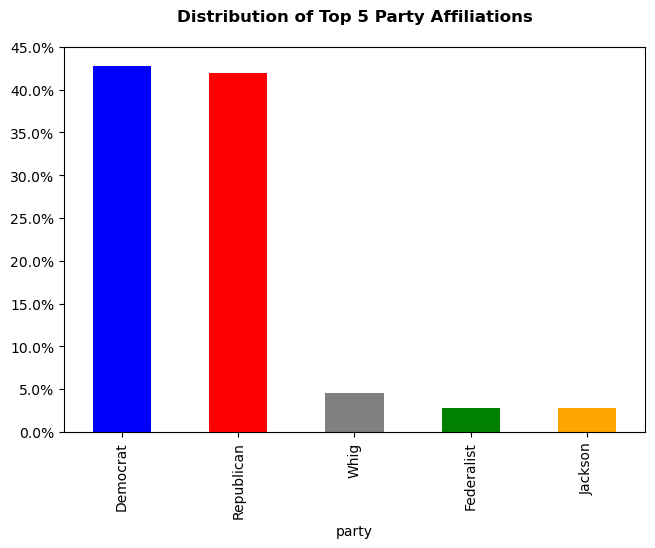

In [6]:
(legislator_attributes_df.value_counts('party', normalize=True)*100)[:5].plot(kind='bar', figsize=(7.5,5), 
                                                                              color=['blue', 'red', 'grey', 'green', 'orange'])

plt.yticks(ticks=np.arange(0.0,50,5), labels=[str(i)+'%' for i in np.round((np.arange(0.00, 50, 5)),2)])
plt.title('Distribution of Top 5 Party Affiliations\n', weight='bold', fontsize=12)

plt.show()

In [7]:
#creating a fact table of the legislator and their historical years in terms

clms=['bioguide', 'start_term', 'end_term', 'type']

#creating an instance counter
legislator_terms_df=legislators_df[clms].sort_values(by='bioguide').reset_index(drop=True).assign(counter=1)

#create a field with the term number per legislator (i.e., first start_term=1, second term=2, etc.) 
legislator_terms_df=(legislator_terms_df
                     .assign(term_number=lambda df: df.groupby('bioguide')['counter']
                     .cumsum()
                            )
                    )

df=(round(legislator_terms_df.groupby(['type', 'bioguide'], 
                              as_index=False)['term_number'].count()
 
                     .groupby('type')['term_number'].agg(['median', 'mean', 'std', 'max']),2)
  
                     )
df.index.name='Chamber'
df.rename(index={'rep': 'House', 'sen': 'Senate'}, inplace=True)
df.rename({k: k+'_term' for k in df.columns}, axis=1, inplace=True)

print( (f'We find the average number of terms served by the US House of Representatives is {df.iloc[0,1]},\n'
        f'while for members of the US Senate it is {df.iloc[1,1]} terms'))

df

We find the average number of terms served by the US House of Representatives is 3.61,
while for members of the US Senate it is 1.97 terms


,median_term,mean_term,std_term,max_term
Chamber,,,,
House,2.0,3.61,3.44,30
Senate,1.0,1.97,1.35,10


In [8]:
df.iloc[[0,]]=df.iloc[[0,]]*2
df.iloc[[1,]]=df.iloc[[1,]]*6
df.rename({k: k+'_nbr_yrs' for k in df.columns}, axis=1, inplace=True)

print( (f'House members are up for re-election every two years, whereas senate seats are up for relection'
        f' every 6 years.\n'
        
        f'Given this and what we know about the average terms noted above, '
        f'members of the House stay on for about {round(df.iloc[0,1])} years on\naverage'
        f', while members of the Senate stay on for about {round(df.iloc[1,1])} years.'))

df

House members are up for re-election every two years, whereas senate seats are up for relection every 6 years.
Given this and what we know about the average terms noted above, members of the House stay on for about 7 years on
average, while members of the Senate stay on for about 12 years.


,median_term_nbr_yrs,mean_term_nbr_yrs,std_term_nbr_yrs,max_term_nbr_yrs
Chamber,,,,
House,4.0,7.22,6.88,60
Senate,6.0,11.82,8.10,60


In [9]:
legislator_terms_df.drop('counter', axis=1, inplace=True)

legislator_terms_df=(legislator_terms_df.assign(start_year=lambda x: x['start_term'].dt.year,
                                                end_year=lambda x: x['end_term'].dt.year)
                                        .drop(['start_term', 'end_term'], axis=1))

legislator_terms_df=(legislator_terms_df.groupby('bioguide')
.agg({'start_year': 'min', 'end_year': 'max'})
.assign(yrs_in_office=lambda d: d.end_year-d.start_year)
.reset_index())

In [10]:
#check if any term start and end dates are missing
legislator_terms_df[['start_year', 'end_year']].isna().sum()

start_year    0
end_year      0
dtype: int64

In [11]:
longest_serving=(legislator_terms_df.groupby(by='bioguide', as_index=False)['yrs_in_office']
 .max().sort_values('yrs_in_office', ascending=False).head(1))

print('Longest Serving Member of Congress\n')
legislator_attributes_df.merge(longest_serving, on='bioguide', how='inner')

Longest Serving Member of Congress



,bioguide,party,first_name,last_name,gender,birthday,state,type,yrs_in_office
0,D000355,Democrat,John,Dingell,M,1926-07-08,MI,rep,60


In [12]:
shortest_serving=(legislator_terms_df.groupby(by='bioguide', as_index=False)['yrs_in_office']
 .max().sort_values('yrs_in_office', ascending=True).head(1))

print('Shortest Member Tenure of Congress\n')
legislator_attributes_df.merge(shortest_serving, on='bioguide', how='inner')

Shortest Member Tenure of Congress



,bioguide,party,first_name,last_name,gender,birthday,state,type,yrs_in_office
0,E000046,Republican,Alonzo,Edgerton,M,1827-06-07,MN,sen,0


In [13]:
#merge with the legislator_attributes_df frame to get chamber of legislator 
legislator_terms_w_chmbr_df=(legislator_terms_df.
                             merge(legislator_attributes_df[['bioguide', 'type']],
                             on='bioguide', how='inner'))

legislator_terms_w_chmbr_df.head(15)

,bioguide,start_year,end_year,yrs_in_office,type
0,A000001,1951,1953,2,rep
1,A000002,1947,1973,26,rep
2,A000003,1817,1825,8,rep
3,A000004,1843,1849,6,rep
4,A000005,1887,1897,10,rep
5,A000006,1868,1871,3,sen
6,A000007,1875,1877,2,rep
7,A000008,1857,1859,2,rep
8,A000009,1973,1987,14,sen
9,A000010,1954,1955,1,sen


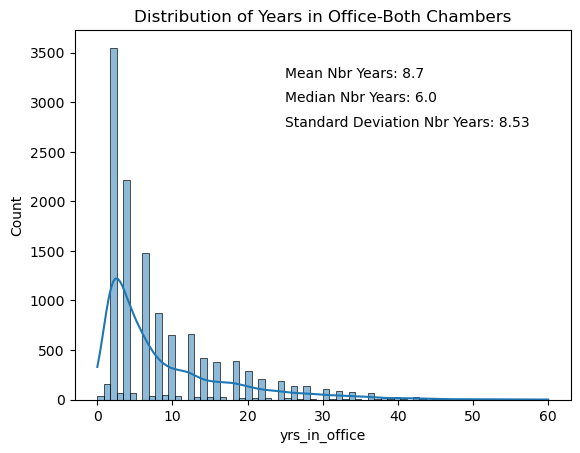


The distribution of years in office show a significant right-skew and is non-normal.


In [14]:
#what's the distribution of years in office?
avg_nbr_yrs=np.mean(legislator_terms_df.yrs_in_office)
med_nbr_yrs=np.median(legislator_terms_df.yrs_in_office)
std_nbr_yrs=np.std(legislator_terms_df.yrs_in_office)

sns.histplot(data=legislator_terms_w_chmbr_df, x='yrs_in_office', kde=True)

plt.text(25,3250, f'Mean Nbr Years: {round(avg_nbr_yrs,2)}')
plt.text(25,3000, f'Median Nbr Years: {round(med_nbr_yrs,2)}')
plt.text(25,2750, f'Standard Deviation Nbr Years: {round(std_nbr_yrs,2)}')
plt.title('Distribution of Years in Office-Both Chambers')
plt.show()

print('\nThe distribution of years in office show a significant right-skew and is non-normal.')

### III. Analysis

#### In order to streamline the analysis,  we'll create a function that takes in a dataframe and the chamber (House or Senate) to output the cohort level time series retention rates.

In [15]:
def cohort_func(df: pd.DataFrame, chmbr: object)->pd.DataFrame:
    
    df_fltr=df.loc[df['type']==chmbr,:].copy()
    cohort_df=df_fltr.copy()
    
    cohort_df=(cohort_df.groupby('start_year', as_index=False)[['bioguide']]
    .nunique()
    .rename({'bioguide': 'cohort_size'}, axis='columns')          
          )

    display(HTML(cohort_df.head(10).to_html()))
    
    legislator_terms_df=(df_fltr.groupby(['start_year', 'yrs_in_office'], 
                                        as_index=False)['bioguide'].count()
                                        .rename({'bioguide': 'nbr_of_legislators'}, axis='columns')
                    )
    
    chmbr_dict={'rep': 'House of Representatives', 'sen': 'Senate'}
    
    print('\n', (f'\n\nFor the {chmbr_dict[chmbr]} {legislator_terms_df.start_year[0]} year cohorts,\n'
             f'{legislator_terms_df.nbr_of_legislators[0]} did not continue in office'
             f' after {legislator_terms_df.yrs_in_office[0]} years, \n'
             f'{legislator_terms_df.nbr_of_legislators[1]} did not'
             f' after {legislator_terms_df.yrs_in_office[1]} years, etc.'
            ))
    
    display(HTML(legislator_terms_df.head(10).to_html()))
    
    merged_df=legislator_terms_df.merge(cohort_df, how='inner', on='start_year')
    
    merged_df=(merged_df
           .assign(pct_dropped=lambda x: round(x.nbr_of_legislators/x.cohort_size,2)
            )
          )

    merged_df['cum_dropped']=merged_df.groupby('start_year')['pct_dropped'].cumsum()

    merged_df['pct_retained']=1-merged_df.cum_dropped

    display(HTML(merged_df.head(15).to_html()))
    
    return merged_df

In [16]:
# US House of Representatives
house_cohorts_df=cohort_func(legislator_terms_w_chmbr_df, 'rep')

,start_year,cohort_size
0,1789,52
1,1790,1
2,1791,23
3,1793,52
4,1795,37
5,1796,1
6,1797,45
7,1798,2
8,1799,37
9,1800,1



 

For the House of Representatives 1789 year cohorts,
15 did not continue in office after 2 years, 
10 did not after 4 years, etc.


,start_year,yrs_in_office,nbr_of_legislators
0,1789,2,15
1,1789,4,10
2,1789,6,8
3,1789,8,8
4,1789,10,2
5,1789,12,4
6,1789,14,1
7,1789,16,1
8,1789,26,2
9,1789,28,1


,start_year,yrs_in_office,nbr_of_legislators,cohort_size,pct_dropped,cum_dropped,pct_retained
0,1789,2,15,52,0.29,0.29,0.71
1,1789,4,10,52,0.19,0.48,0.52
2,1789,6,8,52,0.15,0.63,0.37
3,1789,8,8,52,0.15,0.78,0.22
4,1789,10,2,52,0.04,0.82,0.18
5,1789,12,4,52,0.08,0.90,0.10
6,1789,14,1,52,0.02,0.92,0.08
7,1789,16,1,52,0.02,0.94,0.06
8,1789,26,2,52,0.04,0.98,0.02
9,1789,28,1,52,0.02,1.00,0.00


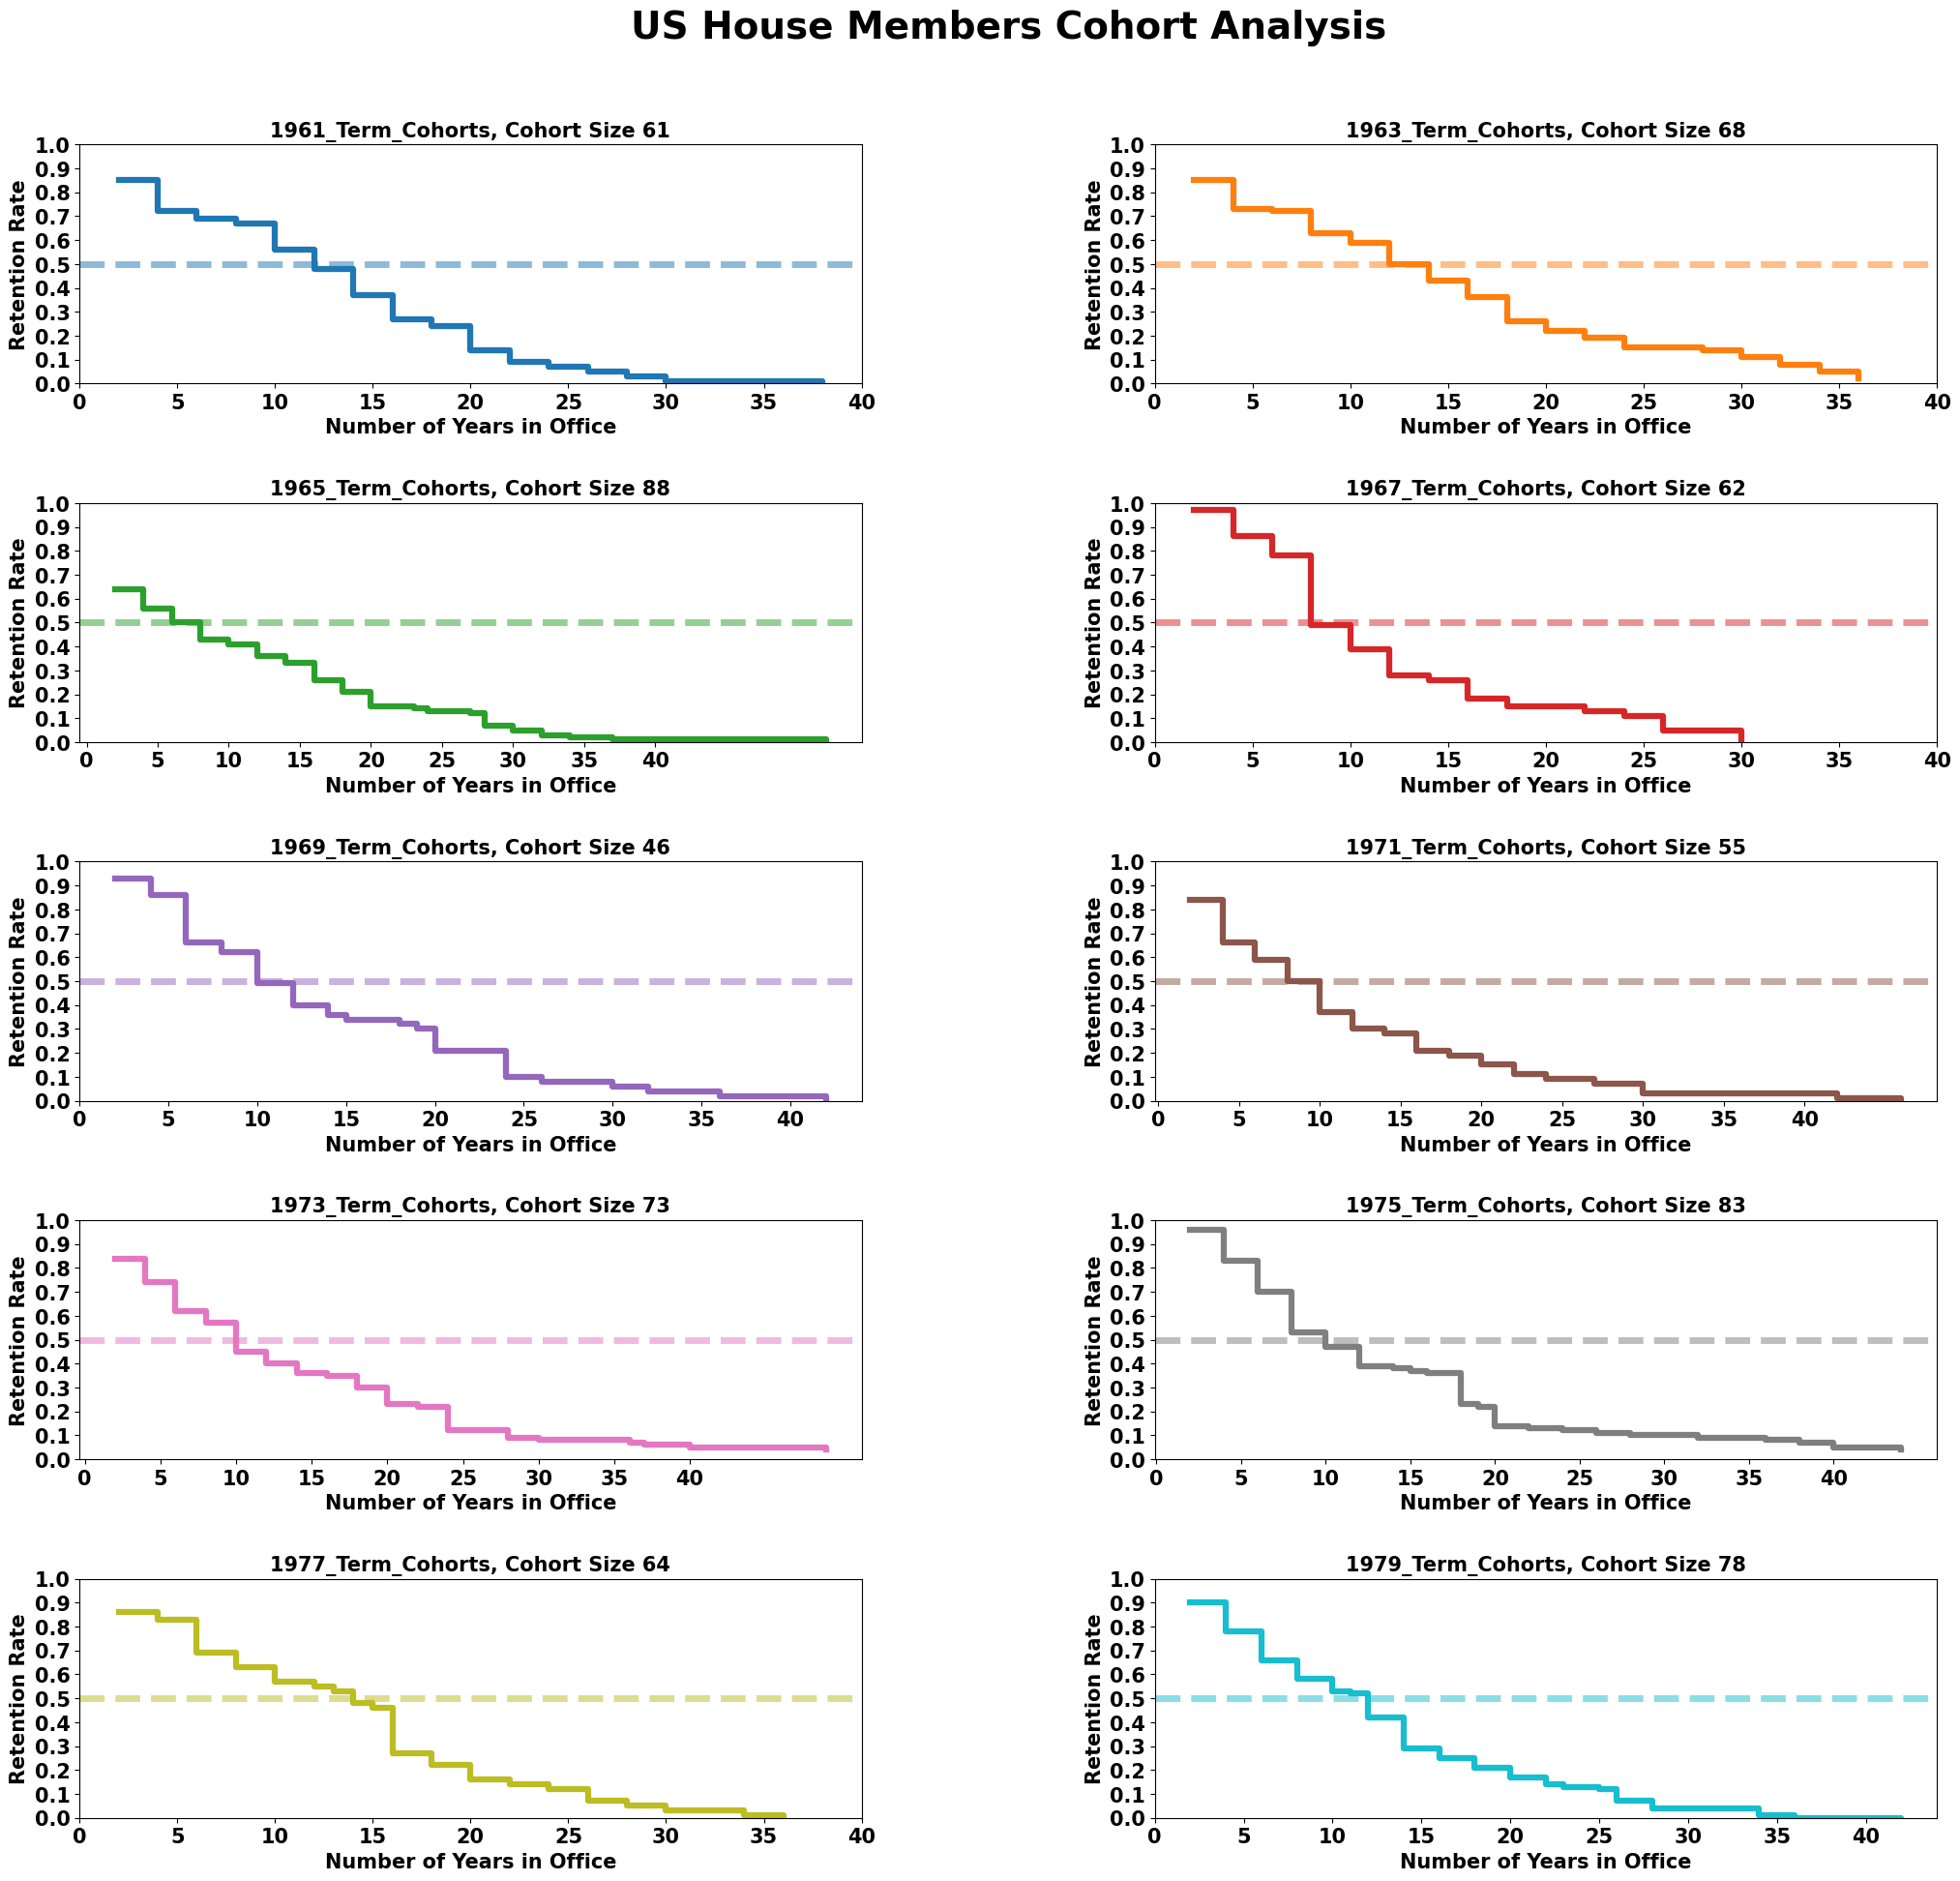

In [17]:
#ensure a house cohort size of 10 or more for a meaningful analysis
house_cohorts_df=house_cohorts_df.query("cohort_size>=10")

#limit the house cohorts to those that became members between 1960 and 1979  
dates=[d for d in house_cohorts_df.start_year.unique() if d>=1960 and d<=1979]

#get the cohort sizes of those respective 1960 to 1979 house cohorts
c_size=(house_cohorts_df.loc[house_cohorts_df.start_year.isin(dates), ['start_year','cohort_size']]
 .groupby('start_year')['cohort_size'].first())

fig, axes = plt.subplots(6, 2, figsize=(32, 28))
fig.tight_layout()

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

lwbase = plt.rcParams['lines.linewidth']
thick = lwbase * 3

fontsize = 15
fontweight = 'bold'
fontproperties = {'weight' : fontweight, 'size' : fontsize}
 
for idx, (dates, c_size, ax, colors) in enumerate(zip(dates, c_size, axes.flatten(), colors)):
    
    sns.lineplot(x='yrs_in_office', y='pct_retained', 
                 data=house_cohorts_df.loc[house_cohorts_df.start_year==dates], 
                 drawstyle='steps-post', ax=ax, color=colors, lw=thick)
    ax.set_title(f'{dates}_Term_Cohorts, Cohort Size {c_size}', fontsize=15, fontweight='bold')
    ax.set_ylim(bottom=0, top=1)
    ax.set_xticks(ticks=np.arange(0,45,5), labels=np.arange(0,45,5), fontproperties=fontproperties)
    ax.set_xlabel('Number of Years in Office', fontsize=15, fontweight='bold')
    
    ax.set_yticks(ticks=np.round(np.arange(0.0, 1.1, 0.1),2), labels=np.round(np.arange(0.0, 1.1, 0.1),2), fontproperties=fontproperties)
    ax.set_ylabel('Retention Rate', fontsize=15, fontweight='bold')
    
    ax.axhline(y=.5, c=colors, linestyle='--', linewidth=5, alpha=0.5)


    #plt.subplots_adjust(wspace=.75, hspace=.5)
    
    plt.subplots_adjust(left=0.2, right=0.8, bottom=0.05, top=0.8, wspace=0.375, hspace=0.5)

    
    plt.suptitle('US House Members Cohort Analysis', fontsize=28, fontweight='bold', y=0.85)
else:
    [ax.set_visible(False) for ax in axes.flatten()[idx+1:]]

plt.show()

#### For the 1961, 1963, 1977, and 1979 House cohorts, we find 50% do not continue onto sucessive terms in the 10 to 15 year period since being first elected.  For example, 50% of the 1961 and 1963 house cohorts drop out after the 13th year.  

#### In contrast, some of the other year cohorts show a much faster decline.  The 1965 cohorts have a 50% retention rate by their 7th year in office.  This corresponds to 1972 and it may be worth understanding the underlying political environment at the time.  

In [18]:
senate_cohorts_df=cohort_func(legislator_terms_w_chmbr_df, 'sen')

,start_year,cohort_size
0,1789,37
1,1790,5
2,1791,14
3,1792,3
4,1793,14
5,1794,3
6,1795,12
7,1796,5
8,1797,10
9,1798,5



 

For the Senate 1789 year cohorts,
6 did not continue in office after 2 years, 
7 did not after 4 years, etc.


,start_year,yrs_in_office,nbr_of_legislators
0,1789,2,6
1,1789,4,7
2,1789,6,3
3,1789,8,4
4,1789,10,2
5,1789,11,1
6,1789,12,6
7,1789,16,2
8,1789,18,2
9,1789,20,1


,start_year,yrs_in_office,nbr_of_legislators,cohort_size,pct_dropped,cum_dropped,pct_retained
0,1789,2,6,37,0.16,0.16,0.84
1,1789,4,7,37,0.19,0.35,0.65
2,1789,6,3,37,0.08,0.43,0.57
3,1789,8,4,37,0.11,0.54,0.46
4,1789,10,2,37,0.05,0.59,0.41
5,1789,11,1,37,0.03,0.62,0.38
6,1789,12,6,37,0.16,0.78,0.22
7,1789,16,2,37,0.05,0.83,0.17
8,1789,18,2,37,0.05,0.88,0.12
9,1789,20,1,37,0.03,0.91,0.09


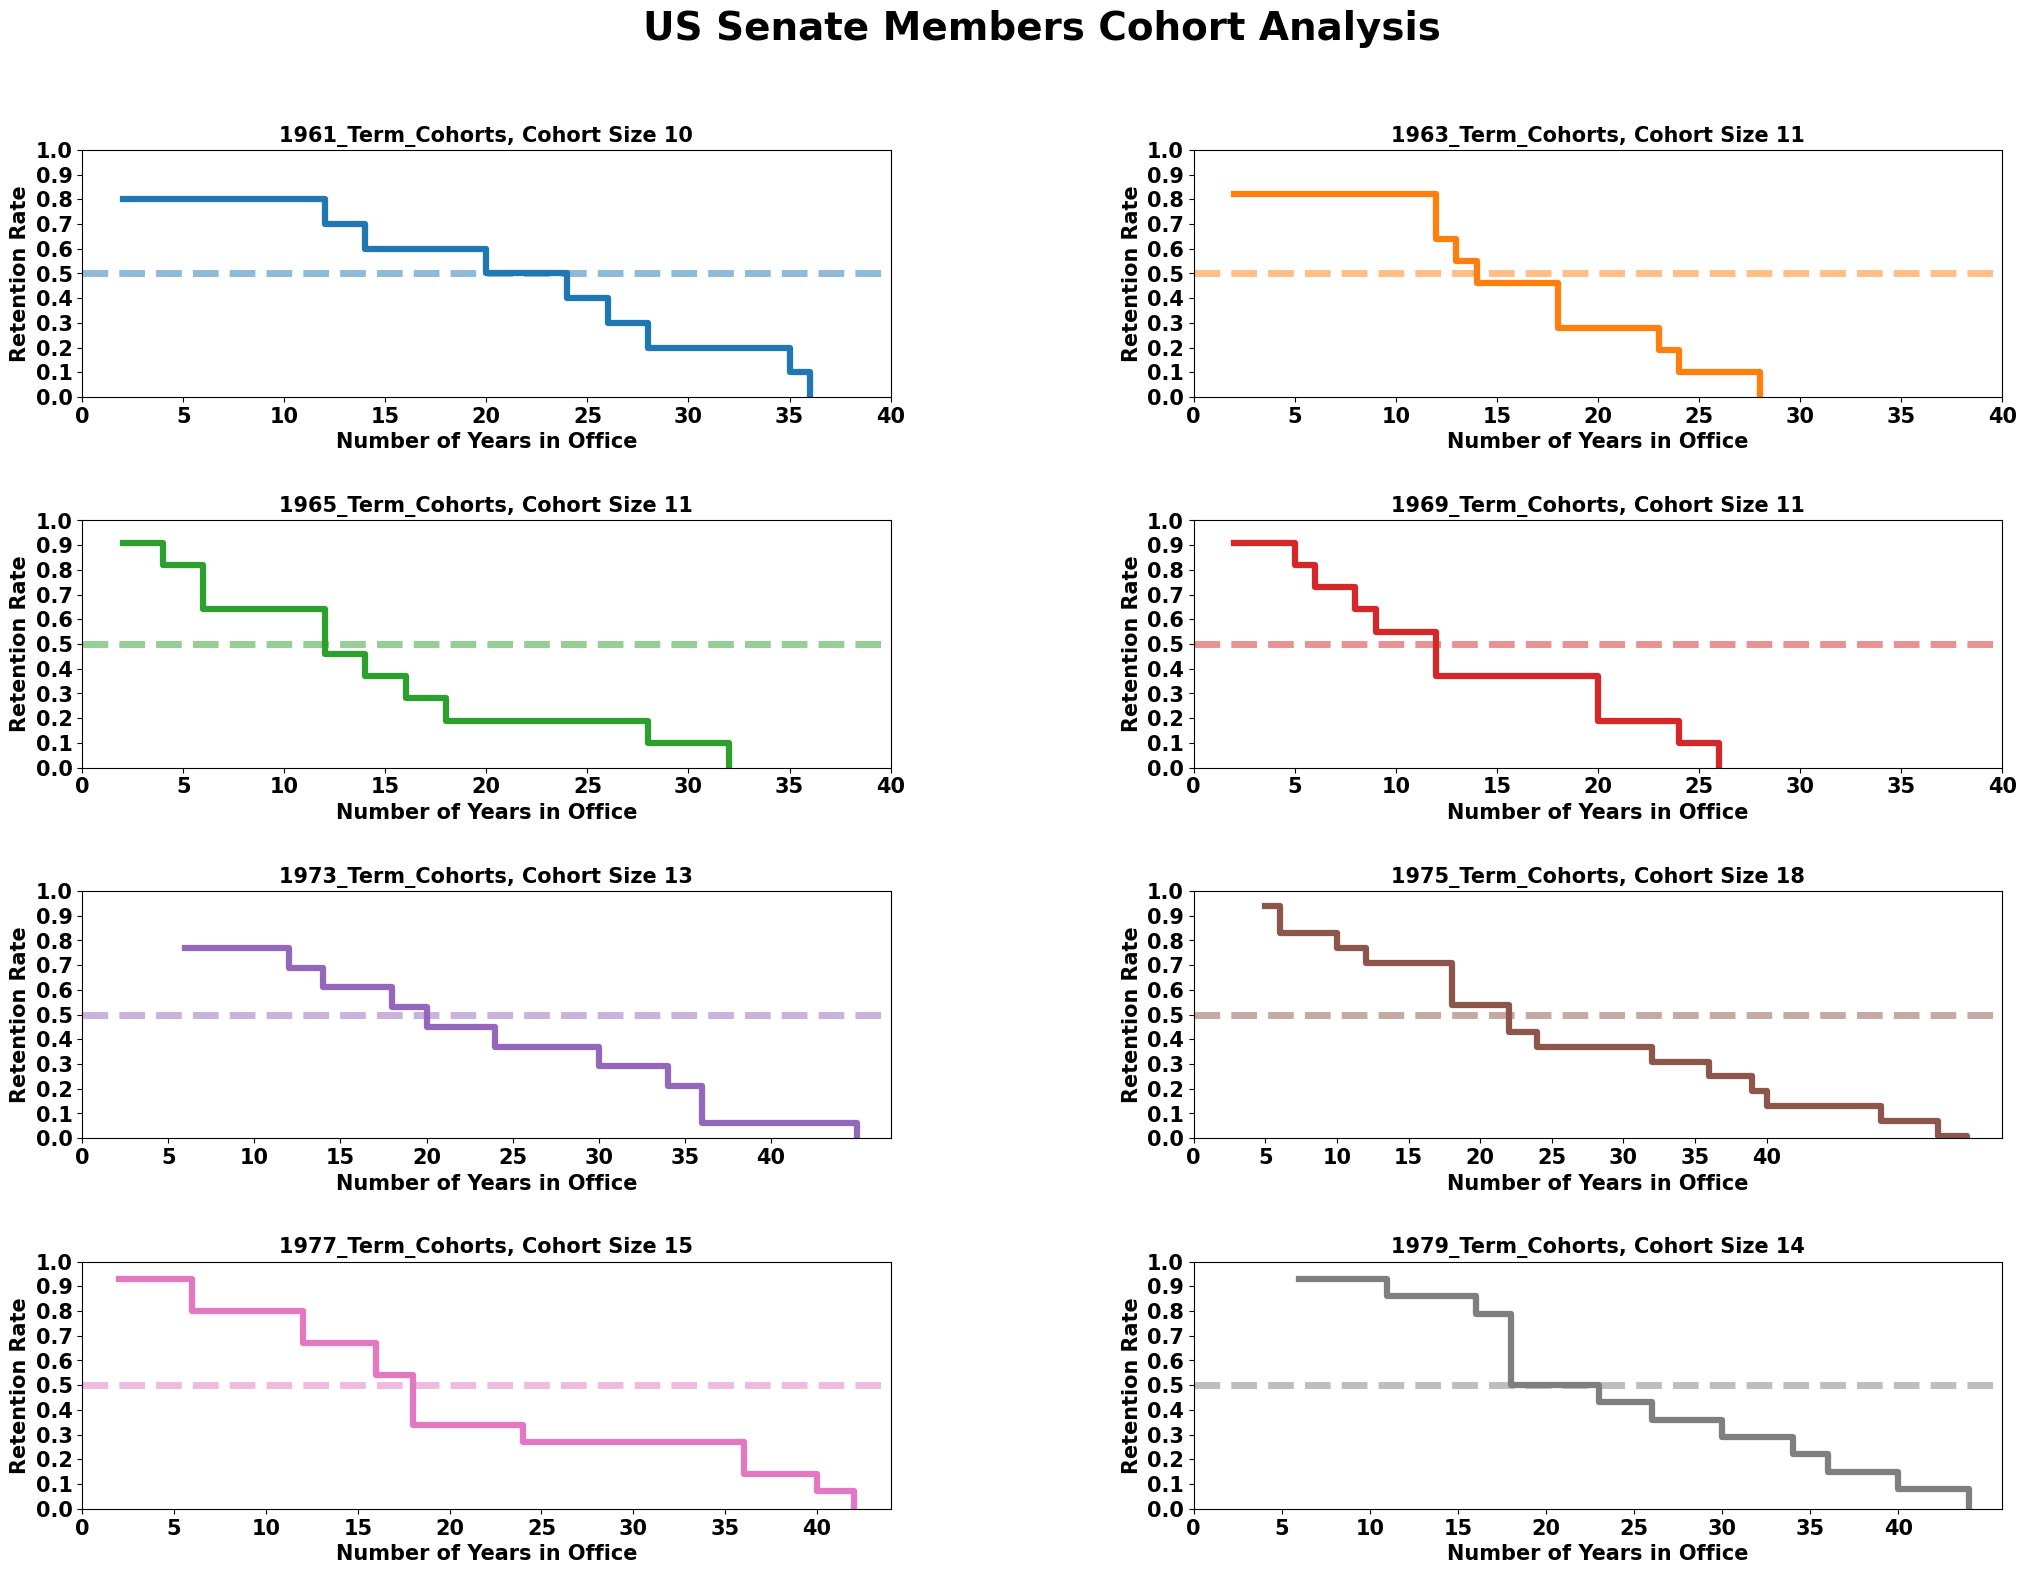

In [19]:
#ensure a senate cohort size of 10 or more for a meaningful analysis
senate_cohorts_df=senate_cohorts_df.query("cohort_size>=10")

#limit the senate cohorts to those that became members between 1960 and 1979  
dates=[d for d in senate_cohorts_df.start_year.unique() if d>=1960 and d<=1979]

#get the cohort sizes of those respective 1960 to 1979 senate cohorts
c_size=(senate_cohorts_df.loc[senate_cohorts_df.start_year.isin(dates), ['start_year','cohort_size']]
 .groupby('start_year')['cohort_size'].first())


fig, axes = plt.subplots(6, 2, figsize=(32, 28))
fig.tight_layout()

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

lwbase = plt.rcParams['lines.linewidth']
thick = lwbase * 3

fontsize = 15
fontweight = 'bold'
fontproperties = {'weight' : fontweight, 'size' : fontsize}
 
for idx, (dates, c_size, ax, colors) in enumerate(zip(dates, c_size, axes.flatten(), colors)):
    
    sns.lineplot(x='yrs_in_office', y='pct_retained', 
                 data=senate_cohorts_df.loc[senate_cohorts_df.start_year==dates], 
                 drawstyle='steps-post', ax=ax, color=colors, lw=thick)
    ax.set_title(f'{dates}_Term_Cohorts, Cohort Size {c_size}', fontsize=15, fontweight='bold')
    ax.set_ylim(bottom=0, top=1)
    ax.set_xticks(ticks=np.arange(0,45,5), labels=np.arange(0,45,5), fontproperties=fontproperties)
    ax.set_xlabel('Number of Years in Office', fontsize=15, fontweight='bold')
    
    ax.set_yticks(ticks=np.round(np.arange(0.0, 1.1, 0.1),2), labels=np.round(np.arange(0.0, 1.1, 0.1),2), fontproperties=fontproperties)
    ax.set_ylabel('Retention Rate', fontsize=15, fontweight='bold')
    
    ax.axhline(y=.5, c=colors, linestyle='--', linewidth=5, alpha=0.5)


    #plt.subplots_adjust(wspace=.75, hspace=.5)
    
    plt.subplots_adjust(left=0.2, right=0.8, bottom=0.05, top=0.8, wspace=0.375, hspace=0.5)

    plt.suptitle('US Senate Members Cohort Analysis', fontsize=28, fontweight='bold', y=0.85)
else:
    [ax.set_visible(False) for ax in axes.flatten()[idx+1:]]

plt.show()

#### Retention for Senate cohorts is mixed.  50% of the 1963, 1965, and 1969 cohorts did not continue onto sucessive terms after being in office 10 to 15 years.  For other cohorts (e.g. 1961, 1975, 1979) 50% are still in office within the 20 to 25 year window from first being elected.  

### IV: Conclusion

Cohort analysis can uncover insights, trends, and is a useful analytical application of time series data.  It is used by marketing teams for lifetime value models (LTV) and, more generally, to understand historical patterns.  It can also serve as a precursor to form hypotheses to validate in future A/B tests.

While the US Congress cohort analysis did not reveal any specific shift in retention rates (politics is complicated and factors such as the economy and voter sentiment can be determinants), we were able to visualize in which years 50% of cohorts are retained and 50% do not go onto sucessive terms.  